Data source: https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import ipywidgets

In [2]:
from matplotlib import rcParams
rcParams["font.size"]=14

In [3]:
co2_data_source = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"

In [4]:
# read data and do some data cleaning 
co2_data = pd.read_csv(
    co2_data_source, skiprows=np.arange(0, 56), na_values="-99.99",
)

In [5]:
co2_data

,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm].1
0,1958,1,21200,1958.0411,NaN,NaN,NaN,NaN,NaN,NaN
1,1958,2,21231,1958.1260,NaN,NaN,NaN,NaN,NaN,NaN
2,1958,3,21259,1958.2027,315.70,314.44,316.18,314.90,315.70,314.44
3,1958,4,21290,1958.2877,317.45,315.16,317.29,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
...,...,...,...,...,...,...,...,...,...,...
751,2020,8,44058,2020.6230,NaN,NaN,NaN,NaN,NaN,NaN
752,2020,9,44089,2020.7077,NaN,NaN,NaN,NaN,NaN,NaN
753,2020,10,44119,2020.7896,NaN,NaN,NaN,NaN,NaN,NaN
754,2020,11,44150,2020.8743,NaN,NaN,NaN,NaN,NaN,NaN


## What are our data? 

The data file below contains 10 columns.  Columns 1-4 give the dates in several redundant  formats. Column 5 below gives monthly Mauna Loa CO2 concentrations in micro-mol CO2 per  mole (ppm), reported on the 2008A SIO manometric mole fraction scale.  This is the  standard version of the data most often sought.  The monthly values have been adjusted  to 24:00 hours on the 15th of each month.  Column 6 gives the same data after a seasonal adjustment to remove the quasi-regular seasonal cycle.  The adjustment involves  subtracting from the data a 4-harmonic fit with a linear gain factor.  Column 7 is a  smoothed version of the data generated from a stiff cubic spline function plus 4-harmonic  functions with linear gain.  Column 8 is the same smoothed version with the seasonal  cycle removed.  Column 9 is identical to Column 5 except that the missing values from  Column 5 have been filled with values from Column 7.  Column 10 is identical to Column 6   except missing values have been filled with values from Column 8.  Missing values are  denoted by -99.99                                                                         

In [6]:
co2_data.columns = [
    "year", "month", "date (int)", "date", "co2", "seasonally adjusted",
    "fit", "seasonally adjusted fit", "co2 filled", "seasonally adjusted filled" 
]

In [7]:
co2_data

,year,month,date (int),date,co2,seasonally adjusted,fit,seasonally adjusted fit,co2 filled,seasonally adjusted filled
0,1958,1,21200,1958.0411,NaN,NaN,NaN,NaN,NaN,NaN
1,1958,2,21231,1958.1260,NaN,NaN,NaN,NaN,NaN,NaN
2,1958,3,21259,1958.2027,315.70,314.44,316.18,314.90,315.70,314.44
3,1958,4,21290,1958.2877,317.45,315.16,317.29,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
...,...,...,...,...,...,...,...,...,...,...
751,2020,8,44058,2020.6230,NaN,NaN,NaN,NaN,NaN,NaN
752,2020,9,44089,2020.7077,NaN,NaN,NaN,NaN,NaN,NaN
753,2020,10,44119,2020.7896,NaN,NaN,NaN,NaN,NaN,NaN
754,2020,11,44150,2020.8743,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# grab the subset of data where co2 do not have NaNs
inds = ~np.isnan(co2_data["co2"])  
co2_data_clean = co2_data[inds]
co2_data_clean

,year,month,date (int),date,co2,seasonally adjusted,fit,seasonally adjusted fit,co2 filled,seasonally adjusted filled
2,1958,3,21259,1958.2027,315.70,314.44,316.18,314.90,315.70,314.44
3,1958,4,21290,1958.2877,317.45,315.16,317.29,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
6,1958,7,21381,1958.5370,315.86,315.19,315.86,315.21,315.86,315.19
7,1958,8,21412,1958.6219,314.93,316.19,313.99,315.28,314.93,316.19
...,...,...,...,...,...,...,...,...,...,...
744,2020,1,43845,2020.0410,413.37,413.32,412.95,412.89,413.37,413.32
745,2020,2,43876,2020.1257,414.09,413.33,413.87,413.10,414.09,413.33
746,2020,3,43905,2020.2049,414.51,412.94,414.89,413.30,414.51,412.94
747,2020,4,43936,2020.2896,416.18,413.35,416.35,413.50,416.18,413.35


In [14]:
def plot_co2(data=co2_data_clean, ax=None, xlim=None, ylim=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(
        data["date"], data["co2"], 
        label="CO$_2$ [ppm]"
    )
    ax.plot(
        data["date"], data["seasonally adjusted"], 
        label="seasonally adjusted",
    )
    ax.set_xlabel("Year")
    ax.set_ylabel("CO$_2$ Concentration (ppm)")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid()
    return ax

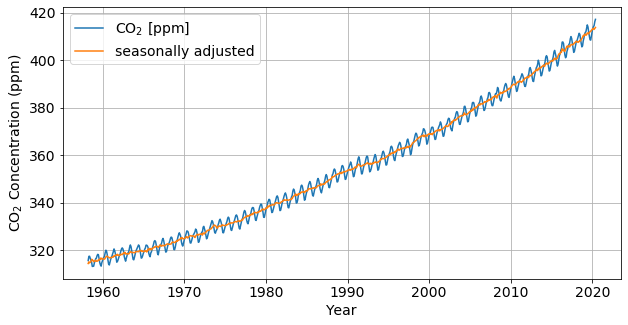

In [15]:
ax = plot_co2()
ax.legend()

## Moving average to remove seasonal variations

Does using a moving average produce similar results as the seasonally adjusted data provided by scripps? 

In [11]:
def moving_average(data, window_size=1):
    n_data = len(data)
    average = np.full(n_data, np.nan)
    half_window = window_size // 2
    for i in range(half_window, n_data - half_window):
        average[i] = np.mean(data[i - half_window: i + half_window])
    return average

In [59]:
def plot_co2_average(window_size=1, xmin=None, xmax=None, ymin=None, ymax=None):
    averaged_co2 = moving_average(co2_data_clean["co2"], window_size)

    ax=plot_co2(co2_data_clean)
    ax.plot(
        co2_data_clean["date"], averaged_co2, 
        label=f"moving average: {window_size}"
    )
    ax.legend()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

In [65]:
ipywidgets.interactive(
    plot_co2_average, 
    window_size=ipywidgets.IntSlider(min=1, max=60, value=6),
    xmin=ipywidgets.FloatText(value=1955), 
    xmax=ipywidgets.FloatText(value=2025),
    ymin=ipywidgets.FloatText(value=310),
    ymax=ipywidgets.FloatText(value=425)
)

interactive(children=(IntSlider(value=6, description='window_size', max=60, min=1), FloatText(value=1955.0, de…